In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as st
# import scipy.linalg as linalg
# import scipy.optimize as so
# import statsmodels.api as sm
# import statsmodels.graphics.tsaplots as sm 
import random
# import time
import math
from sklearn.linear_model import LinearRegression


# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from numpy import matlib
# from scipy import io
# from scipy.special import erf
# from scipy.fftpack import fft, ifft
# from scipy import interpolate as intrp
# from matplotlib import rc
# from tools import *

np.random.seed(42)

# Point 1 - Basic ABC rejection algorithm

In [2]:
def discrepancy_metric(x, sample_mean=0):
    # rho(S(D*),S(D)) = abs(mean(x*) - mean(x)), we assume that mean(x)=0 (sample mean)
    return abs(np.mean(x) - sample_mean)

def true_mixture_distribution(x, M, a, var, var_1, sample_mean=0):
    alfa = 1./( 1 + np.exp( a * (sample_mean - 0.5*a) * M / (M*var + var_1) ) )
    pdf_1 = alfa * st.norm.pdf(x=x, loc = var/(var+var_1/M)*sample_mean, scale = np.sqrt(var_1/(M+var_1/var)))
    pdf_2 = (1-alfa) * st.norm.pdf(x=x, loc = var/(var+var_1/M)*(sample_mean-a), scale = np.sqrt(var_1/(M+var_1/var)))
    # f = alfa * st.norm(loc = var/(var+var_1/M)*sample_mean, scale = var_1/(M+var_1/var)) + (1-alfa) * st.norm(loc = var/(var+var_1/M)*(sample_mean-a), scale = var_1/(M+var_1/var))
    f = pdf_1 + pdf_2
    return f

def generate_data(M, theta, var, var_1, a):
    D = np.zeros(M)
    # do stuff ...
    return D

def basic_abc(N, M, eps, var, var_1, a):
    theta = np.zeros(N) #at the end of the algorithm it has to be full (algorithm ends when we have selected N samples)
    pi_rv = st.norm(loc=0, scale=np.sqrt(var))
    rejection_count = 0
    n1_count = 0  #DEBUG
    n2_count = 0  #DEBUG
    i = 0 # count of the number of selected samples
    
    while i < N:
        # sample candidate parameters from the prior distribution pi = N(0,var)
        theta_star = pi_rv.rvs()
    
        # generate data from the underlying model given theta_star
        # D observed data, is an iid sample drawn with prob=0.5 from N(theta,var_1), o/w from N(theta+a,var_1)
        N1_rv = st.norm(loc=theta_star, scale=np.sqrt(var_1))
        N2_rv = st.norm(loc=theta_star + a, scale=np.sqrt(var_1))
        D = np.zeros(M)
        
        #build a set of M observation from the underlying model given theta_star
        if np.random.choice([0, 1]) == 0:
            for j in range(M):
                D[j] = N1_rv.rvs()
                n1_count += 1
        else:
            for j in range(M):
                D[j] = N2_rv.rvs()
                n2_count += 1
        
        if discrepancy_metric(D) < eps:
            theta[i] = theta_star
            i += 1 # a new sample is selected
        else:
            rejection_count += 1
    
    print('acceptance rate:', N/(N + rejection_count))
    return theta, N/(N + rejection_count)

In [3]:
# set problem parameters
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances
N = 500  # max number of accepted samples

In [4]:
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)

theta_list = []
acc_rates_basic_ABC = []

for e in eps:
    theta, acc_rate = basic_abc(N, M, e, var, var_1, a)
    theta_list.append(theta)
    acc_rates_basic_ABC.append(acc_rate)

acceptance rate: 0.3190810465858328
acceptance rate: 0.11165698972755694
acceptance rate: 0.043044077134986224
acceptance rate: 0.010387020379333985


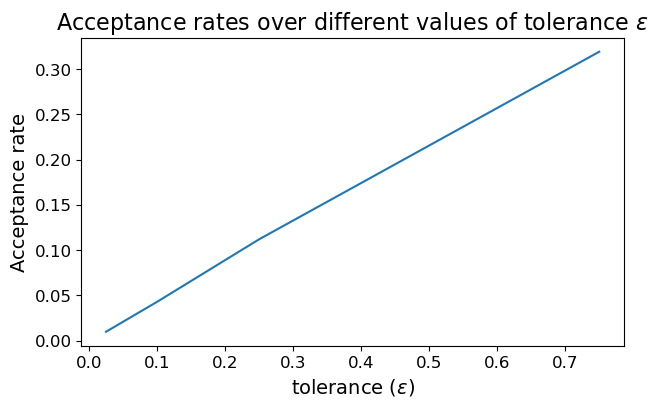

In [47]:
plt.figure(figsize=(7,4))

plt.plot(eps, acc_rates_basic_ABC)

plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title(r'Acceptance rates over different values of tolerance $\epsilon$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.show()

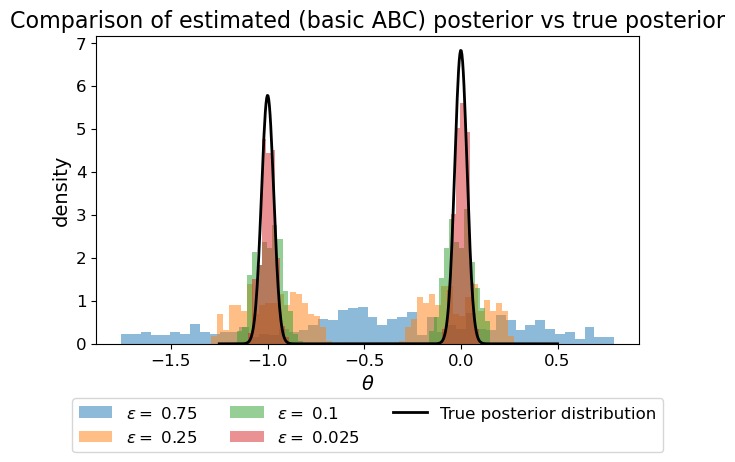

In [25]:
plt.figure(figsize=(7,4))

for i in (range(len(eps))):
    plt.hist(theta_list[i], density=True, bins=50, alpha=0.5, label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True posterior distribution', color='black', linewidth=2)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Comparison of estimated (basic ABC) posterior vs true posterior', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize='large')  
plt.show()

In [26]:
sample_mean = 0

print("mu1 is:", var/(var+var_1/M)*sample_mean, ", sdt1 is:", np.sqrt(var_1/(M+var_1/var)))
print("mu2 is:", var/(var+var_1/M)*(sample_mean-a), ", std2 is:", np.sqrt(var_1/(M+var_1/var)))
print("alpha is:",alpha)

print("mean of true mixture distribution is:",(1-alpha)*var/(var+var_1/M)*(sample_mean-a))

mu1 is: 0.0 , sdt1 is: 0.03161750745616664
mu2 is: -0.9996667777407531 , std2 is: 0.03161750745616664
alpha is: 0.5415566948980146
mean of true mixture distribution is: -0.4582905415881227


# Point 3 - ABC-MCMC algorithm

## ver. 1.1 - effective sample size

In [36]:
def abc_mcmc(N_max, M, eps, nu_squared, var, var_1, a):
    theta = np.zeros(N_max+1)
    pi_rv = st.norm(loc=0, scale=np.sqrt(nu_squared))  # prior 
    
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    metropoli_ratio_list = []
    
    while i < N_max:
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # random walk proposal q(theta, ) = N(theta,nu_squared)
        q_i = st.norm(loc=theta[i], scale=np.sqrt(nu_squared))
        theta_star = q_i.rvs()
    
        # generate data from the underlying model given theta_star
        N1_rv = st.norm(loc=theta_star, scale=np.sqrt(var_1))
        N2_rv = st.norm(loc=theta_star + a, scale=np.sqrt(var_1))
        
        D = np.zeros(M)
        if np.random.choice([0, 1]) == 0:
            for j in range(M):
                D[j] = N1_rv.rvs()
                # n1_count = n1_count + 1
        else:
            for j in range(M):
                D[j] = N2_rv.rvs()
                # n2_count = n1_count + 1
    
        if discrepancy_metric(D) < eps:
            q_star = st.norm(loc=theta_star, scale=np.sqrt(nu_squared))
            comp = pi_rv.pdf(theta_star)*q_star.pdf(theta[i])/( pi_rv.pdf(theta[i])*q_i.pdf(theta_star) )
            metropoli_ratio_list.append(min(1.,comp))
            
            entered += 1
            
            if st.uniform.rvs() < comp:
                theta[i+1] = theta_star
                acceptance_count += 1 
            else:
                theta[i+1] = theta[i]
                rejection_count += 1
        else:
            theta[i+1] = theta[i]
            rejection_count += 1
            
        i += 1
    
    #print("acceptance count is:", acceptance_count, "; count of rho < epsilon is:", entered, "; rejection count is:", rejection_count) ## DEBUG
    #if acceptance_count == 500:
    #    print('effective sample size achieved')
    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    return theta, acceptance_count/(acceptance_count+rejection_count)

In [37]:
### Update effective sample size: ESS = N c(0)/sigma^2
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0

eps = [0.75, 0.25, 0.1, 0.025]  # tolerances

N_eff = 500  # effective size
nu_squared = 1  # TEMP

# estimate the asymptotic variance (covariance method)
N_max = 5000  # 10*N_eff
e = 0.1

c_hat = []
theta, acc_rate = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)

acceptance count is: 296 ; count of rho < epsilon is: 326 ; rejection count is: 4704
acceptance rate: 0.0592


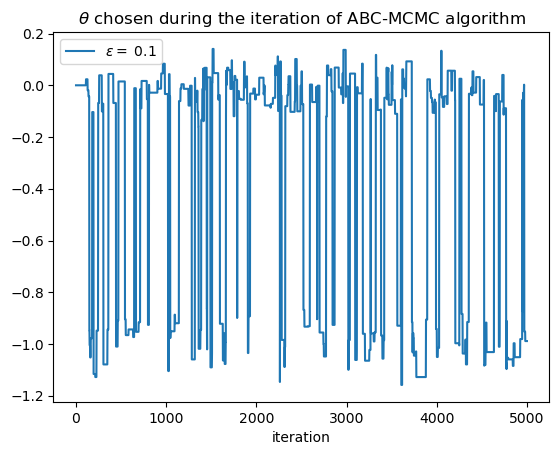

In [38]:
plt.figure()
plt.plot(theta, label = r'$\epsilon =$ %s' % e)
plt.legend()
plt.xlabel('iteration')
plt.title(r'$\theta$ chosen during the iteration of ABC-MCMC algorithm')

plt.show()

We estimate now the number of iterations to have $N_{eff} \approx 500$.

In [40]:
### update (cont.)
b = 1000  # burn-in
mu_hat = theta[b:].mean()

k = 0
while k < N_max-1:
    c_hat.append(1/(N_max-k-1)*np.multiply(theta[b:N_max-k+1] - mu_hat, theta[b+k:] - mu_hat).sum())
    k = k + 1

In [41]:
### update (cont.)
for k, _ in enumerate(c_hat):
    if c_hat[2*k] - c_hat[2*k+1] < 0:
        M_eff = 2*k
        break
print(M_eff)

144


In [42]:
var_M_hat = c_hat[0] + 2*sum(c_hat[1:M_eff+1])
var_hat = c_hat[0] + 2*sum(c_hat[1:])

print('sigma^2^hat =', var_hat)
print('sigma^2^hat_M =', var_M_hat)

sigma^2^hat = -14.953182296093173
sigma^2^hat_M = 8.165322986598353


In [43]:
N_max = math.ceil(N_eff*var_M_hat/c_hat[0])
print('N_max =', N_max)

N_max = 22125


Now let us plot as in basic MCMC the estimated posterior for different values of $\epsilon$.

In [44]:
### update (cont.)
x_values = np.linspace(-1.25, 0.5, 500)
f = true_mixture_distribution(x_values, M, a, var, var_1, sample_mean=0)
theta_list = []
acc_rates_ABC_MCMC = []

for e in eps:
    theta, acc_rate = abc_mcmc(N_max, M, e, nu_squared, var, var_1, a)
    theta_list.append(theta)
    acc_rates_ABC_MCMC.append(acc_rate)

acceptance count is: 8509 ; count of rho < epsilon is: 9759 ; rejection count is: 13616
acceptance rate: 0.3845875706214689
acceptance count is: 3045 ; count of rho < epsilon is: 3434 ; rejection count is: 19080
acceptance rate: 0.1376271186440678
acceptance count is: 1313 ; count of rho < epsilon is: 1445 ; rejection count is: 20812
acceptance rate: 0.059344632768361584
acceptance count is: 289 ; count of rho < epsilon is: 331 ; rejection count is: 21836
acceptance rate: 0.013062146892655366


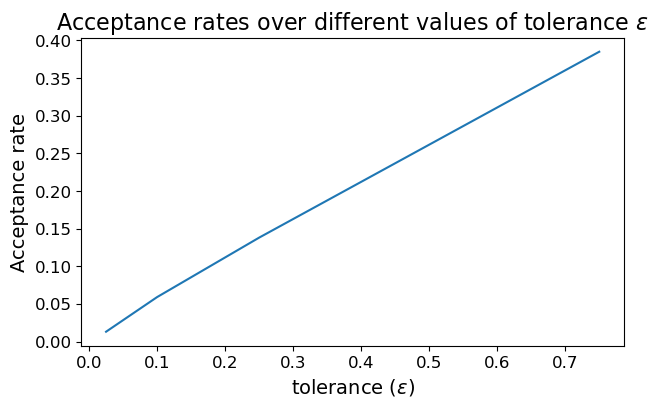

In [48]:
acc_rates_ABC_MCMC = [0.385, 0.138, 0.059, 0.013]

plt.figure(figsize=(7,4))

plt.plot(eps, acc_rates_ABC_MCMC)
plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title(r'Acceptance rates over different values of tolerance $\epsilon$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.show()

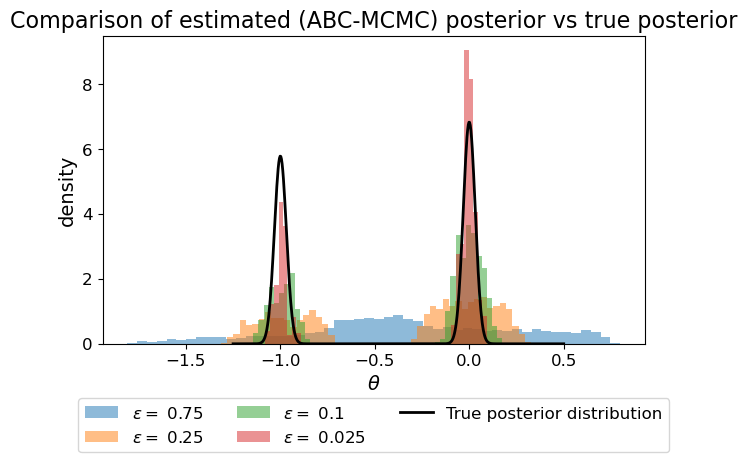

In [45]:
plt.figure(figsize=(7,4))

for i in (range(len(eps))):
    plt.hist(theta_list[i], density=True, bins=50, alpha=0.5, label=r'$\epsilon =$ %s' % eps[i])
    
plt.plot(x_values, f, label='True posterior distribution', color='black', linewidth=2)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('density', fontsize=14)
plt.title('Comparison of estimated (ABC-MCMC) posterior vs true posterior', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize='large')  
plt.show()

We can look also at the evolution of the samples $\theta_i$ chosen by ABC-MCMC algorithm

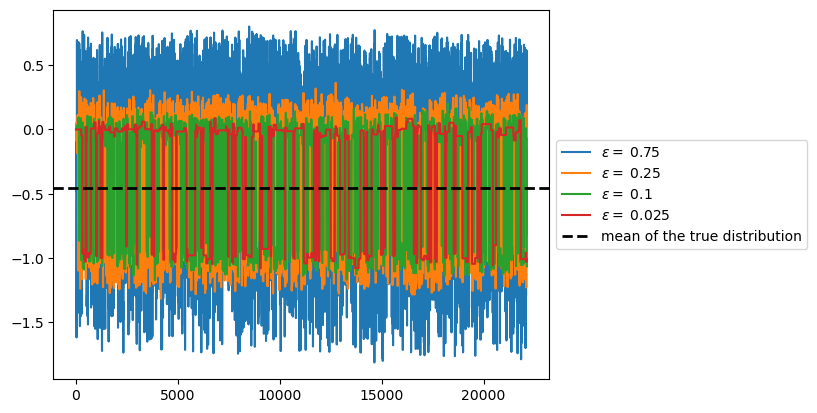

In [49]:
plt.figure()

for i in (range(len(eps))):
    plt.plot(theta_list[i], label=r'$\epsilon =$ %s' % eps[i])
    
plt.axhline(y=(1-alpha)*(sample_mean-a), color='black', linestyle='--', linewidth=2, label='mean of the true distribution')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

**Comparison acceptance rates**

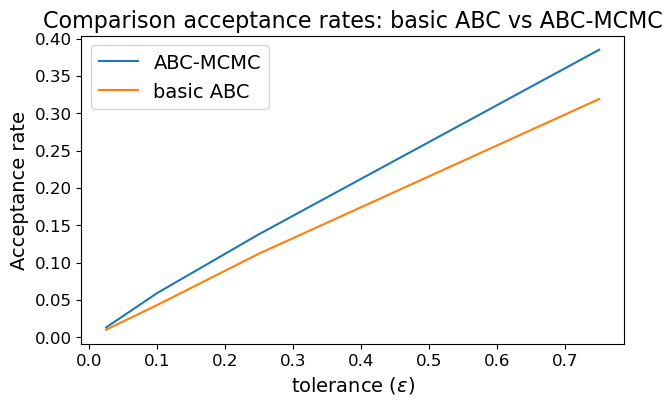

In [52]:
acc_rates_ABC_MCMC = [0.385, 0.138, 0.059, 0.013]
acc_rates_basic_ABC = [0.319, 0.112, 0.043, 0.010]

plt.figure(figsize=(7,4))

plt.plot(eps, acc_rates_ABC_MCMC, label='ABC-MCMC')
plt.plot(eps, acc_rates_basic_ABC, label='basic ABC')

plt.xlabel(r'tolerance ($\epsilon$)', fontsize=14)
plt.ylabel('Acceptance rate', fontsize=14)
plt.title('Comparison acceptance rates: basic ABC vs ABC-MCMC', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')
plt.legend(fontsize=14)

plt.show()

# Point 4 - Calculate summary statistic

In [53]:
# Define parameters of pharmacokinetic model
K_e = 0.08
K_a = 1.5
Cl = 0.04
sigma = 0.2
D = 4

Let us use the Euler-Maruyama method to estimate $X(t)$.

In [57]:
def simulate_Xt_times(K_e, K_a, Cl, sigma):
    np.random.seed(42)
    dt = 0.05  # Time step
    T = 12  # Total time
    n = int(T / dt)+1  # Number of time steps
    D = 4

    t = np.arange(0, 12.05, 0.05)  # Vector of times

    X_t = np.zeros(n) # Recall that X_0 = 0
    for i in range(n - 1):
        X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()
    
    times = [0.25, 0.5, 1, 2, 3.5, 5, 7, 9, 12]
    indices = np.where(np.isin(t, times))
    Data = X_t[indices]
    return Data

def simulate_Xt_full(K_e, K_a, Cl, sigma):
    np.random.seed(42)
    dt = 0.05  # Time step
    T = 12  # Total time
    n = int(T / dt)+1  # Number of time steps
    D = 4

    t = np.arange(0, 12.05, 0.05)  # Vector of times

    X_t = np.zeros(n) # Recall that X_0 = 0
    for i in range(n - 1):
        X_t[i + 1] = X_t[i] + dt*( (D*K_a*K_e)/Cl * np.exp(-K_a*t[i+1]) - K_e*X_t[i] ) + sigma*np.sqrt(dt)*np.random.randn()
    
    return t, X_t

In [58]:
t, X_t = simulate_Xt_full(K_e, K_a, Cl, sigma)

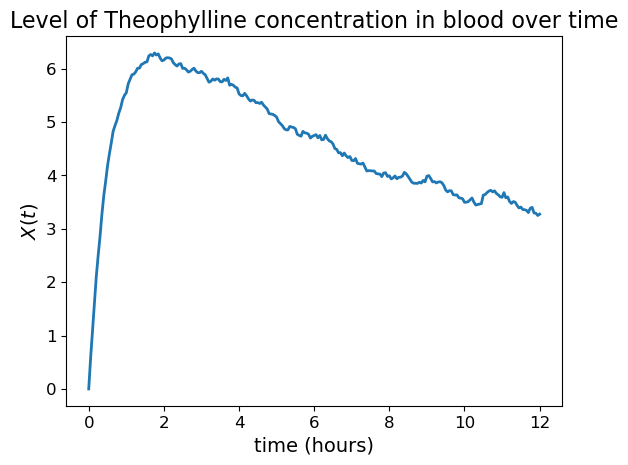

In [62]:
plt.figure()

plt.plot(t, X_t, label=r'$X(t)$', linewidth=2)
plt.xlabel('time (hours)', fontsize=14)
plt.ylabel(r'$X(t)$', fontsize=14)
plt.title('Level of Theophylline concentration in blood over time', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize='large')

plt.show()

We fit now a Linear Regression.

In [63]:
xs = simulate_Xt_times(K_e, K_a, Cl, sigma)
print('data are:', xs)

data are: [2.49026964 4.17926941 5.54835907 6.16128545 5.75647863 5.09252414
 4.28144018 3.98492409 3.27435603]


In [66]:
n_data = 10000
X = np.zeros((n_data, 9)) 
Y = np.zeros((n_data, 4)) #4 is the number of parameters of interest

for j in range(n_data):
    K_a = np.exp(np.random.normal(0.14, 0.4))
    K_e = np.exp(np.random.normal(-2.7, 0.6))
    Cl = np.exp(np.random.normal(-3, 0.8))
    sigma = np.exp(np.random.normal(-1.1, 0.3))
    
    theta = [K_e, K_a, Cl, sigma]
    Y[j,:] = theta

    X[j,:] = simulate_Xt_times(K_e, K_a, Cl, sigma)

In [70]:
# Fit linear regression model
model = LinearRegression()
model.fit(X, Y)

# Get the estimated coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

print("Estimated Coefficients:", coefficients)
print("Intercept:", intercept)

Estimated Coefficients: [[ 0.00030545 -0.00319087 -0.00073235 -0.00044273 -0.00328705  0.00031853
  -0.00201139  0.00436783  0.0001159 ]
 [-0.00101892 -0.0026772  -0.00494607 -0.00776502 -0.00965323 -0.00905608
  -0.00913099 -0.00614112 -0.00574621]
 [-0.00109825  0.00547705 -0.00069257 -0.00256786  0.0025386  -0.00474312
   0.00010227 -0.01191078 -0.00282904]
 [-0.00601725  0.03562375 -0.00067984 -0.01017338  0.02260002 -0.02261774
   0.00723765 -0.06881154 -0.0132409 ]]
Intercept: [0.06869494 0.93304404 0.1049698  0.54960748]


Finally, we can calculate the summary statistic $S(\mathcal{D})$ using the first data we generated. 

$S(\mathcal{D}) = \mathbb{E}[\theta| \mathcal{D}]= \begin{bmatrix} \theta_1 \\ \theta_2 \\ \theta_3 \\ \theta_4 \end{bmatrix} = \begin{bmatrix} \beta_0^{(1)} \\ \beta_0^{(2)} \\ \beta_0^{(3)} \\ \beta_0^{(4)} \end{bmatrix} + \begin{bmatrix} \beta_1^{(1)} \ ... \ \beta_9^{(1)} \\ \beta_1^{(2)} \ ... \ \beta_9^{(2)} \\ \beta_1^{(3)} \ ... \ \beta_9^{(3)} \\ \beta_1^{(4)} \ ... \ \beta_9^{(4)} \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_9 \end{bmatrix}$

In [122]:
S_D = intercept + coefficients@xs
print("Summary statistic is", S_D)
print("They are generated from data with parameters", [0.08,1.5,0.04,0.2])

Summary statistic is [0.0412026  0.65996514 0.03963098 0.34538955]
They are generated from data with parameters [0.08, 1.5, 0.04, 0.2]


# Point 5 - ABC_MCMC on Pmodel and estimate of the posterior mean $\theta^{PM}$

In [109]:
def new_discrepancy_metric(D_star, S_D, intercept, coefficients, theta_0):
    S_D_star = intercept + coefficients@D_star
    
    diff = S_D_star - S_D
    metric = 0
    
    for i in range(len(diff)):
        metric += diff[i]**2/(theta_0[i])**2
        
    return metric

In [172]:
def jointly_prior_sample(prior_K_e, prior_K_a, prior_Cl, prior_sigma, theta):
    # assuming independence
    return prior_K_e.pdf(theta[0])*prior_K_a.pdf(theta[1])*prior_Cl.pdf(theta[2])*prior_sigma.pdf(theta[3])

def abc_mcmc_pharma(N_max, M, eps, var, var_1, a, S_D, intercept, coefficients):
    
    theta = np.zeros((N_max + 1, 4))
    theta_0 = [0.07, 1.15, 0.05, 0.33]
    theta[0,:] = theta_0
    
    prior_K_e = st.lognorm(s=0.6, scale=np.exp(-2.7))
    prior_K_a = st.lognorm(s=0.4, scale=np.exp(0.14))
    prior_Cl = st.lognorm(s=0.8, scale=np.exp(-3))
    prior_sigma = st.lognorm(s=0.3, scale=np.exp(-1.1))
    
    acceptance_count = 0
    rejection_count = 0
    entered = 0
    i = 0
    
    while i < N_max:
        # sample candidate parameters from a proposal transition density q(theta_i, )
        # anisotropic approach
        #q_i = st.lognorm(s=0.5, scale=np.exp(theta[i,:])) #multivariate lognormal
        
        q_i = st.lognorm(s=0.1, scale=theta[i,:]) #lognormal 4 dimensional with different scale and same variance s
        theta_star=q_i.rvs() #sample from the lognormal
        
        # generate data from the underlying model given theta_star
        K_e = theta_star[0]
        K_a = theta_star[1]
        Cl = theta_star[2]
        sigma = theta_star[3]
        
        D_star = simulate_Xt_times(K_e, K_a, Cl, sigma) #generate data from underlying model given theta star
        #print("theta_0:", theta_0)
        #print("theta_star:", theta_star)
        #print("metric:", new_discrepancy_metric(D_star, S_D, intercept, coefficients, theta_0))
        #raise NotImplementedError("HERE")
        
        if new_discrepancy_metric(D_star, S_D, intercept, coefficients, theta_0) < eps:
            
            #prior_K_e_star = st.lognorm(s=0.5, scale=np.exp(theta_star[0]))
            #prior_K_a_star = st.lognorm(s=0.5, scale=np.exp(theta_star[1]))
            #prior_Cl_star = st.lognorm(s=0.5, scale=np.exp(theta_star[2]))
            #prior_sigma_star = st.lognorm(s=0.5, scale=np.exp(theta_star[3]))
            
            #q_star_pdf = jointly_prior_sample(prior_K_e_star, prior_K_a_star, prior_Cl_star, prior_sigma_star, theta[i,:])
            #q_i_pdf = jointly_prior_sample(prior_K_e, prior_K_a, prior_Cl, prior_sigma, theta_star)
            #pi_star = jointly_prior_sample(prior_K_e, prior_K_a, prior_Cl, prior_sigma, theta_star)
            #pi_i = jointly_prior_sample(prior_K_e, prior_K_a, prior_Cl, prior_sigma, theta[i,:])
            
            #comp = pi_star * q_star_pdf/(pi_i * q_i_pdf)
            #comp = min(1,comp)
            
            comp=1
            entered += 1
            
            if st.uniform.rvs() < comp:
                theta[i+1,:] = theta_star
                acceptance_count += 1 
            else:
                theta[i+1,:] = theta[i,:]
                rejection_count += 1
        else:
            theta[i+1,:] = theta[i,:]
            rejection_count += 1
            
        i += 1

    print('acceptance rate:', acceptance_count/(acceptance_count+rejection_count))
    print(entered)
    return theta, acceptance_count/(acceptance_count+rejection_count)

In [177]:
N_max = 10000
M = 100
var_1 = 0.1
var = 3
a = 1
sample_mean = 0  # assumed to be exactly =0
eps = 1

theta, acc_rate = abc_mcmc_pharma(N_max, M, eps, var, var_1, a, S_D, intercept, coefficients)

acceptance rate: 0.0013
13


In [178]:
print(theta)

[[0.07       1.15       0.05       0.33      ]
 [0.06466649 1.13688072 0.05258978 0.35984313]
 [0.05986316 1.34234552 0.05086103 0.34858548]
 ...
 [0.02561198 8.34656749 0.03521335 0.24573455]
 [0.02561198 8.34656749 0.03521335 0.24573455]
 [0.02561198 8.34656749 0.03521335 0.24573455]]


In [179]:
theta_PM = np.mean(theta, axis=0)
theta_SD = [0.08, 1.5, 0.04, 0.2]

print(theta_PM)
print(theta_SD)

[0.02563826 8.3398219  0.03522543 0.24581283]
[0.08, 1.5, 0.04, 0.2]
